<a href="https://colab.research.google.com/github/v-chns/diabetes-prediction-model/blob/main/big-data-project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyspark
!pip install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317130 sha256=83a1f9604eee4c3324816daaeaf2e591628cd4e832558d6e68354c1cc03c3739
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import seaborn as sns
import matplotlib.pyplot as plt

spark = SparkSession.builder.getOrCreate()

# Membaca data
diabetesDataset = spark.read.option("inferSchema", "true").csv("diabetes_prediction_dataset.csv", header=True)

# Memilih kolom - kolom relevan
diabetesDataset = diabetesDataset.select("gender", "age", "hypertension", "heart_disease", "smoking_history",
                                         "bmi", "HbA1c_level", "blood_glucose_level", "diabetes")

diabetesDataset.show()

+------+----+------------+-------------+---------------+-----+-----------+-------------------+--------+
|gender| age|hypertension|heart_disease|smoking_history|  bmi|HbA1c_level|blood_glucose_level|diabetes|
+------+----+------------+-------------+---------------+-----+-----------+-------------------+--------+
|Female|80.0|           0|            1|          never|25.19|        6.6|                140|       0|
|Female|54.0|           0|            0|        No Info|27.32|        6.6|                 80|       0|
|  Male|28.0|           0|            0|          never|27.32|        5.7|                158|       0|
|Female|36.0|           0|            0|        current|23.45|        5.0|                155|       0|
|  Male|76.0|           1|            1|        current|20.14|        4.8|                155|       0|
|Female|20.0|           0|            0|          never|27.32|        6.6|                 85|       0|
|Female|44.0|           0|            0|          never|19.31|  

In [ ]:
# Menghilangkan data null
diabetesDataset = diabetesDataset.na.drop()

# Convert data non-numerik jadi numerik
from pyspark.sql.functions import when
diabetesDataset = diabetesDataset.withColumn("smoking_history", when(diabetesDataset["smoking_history"] == "never", 0)
                                             .when(diabetesDataset["smoking_history"] == "former", 1)
                                             .when(diabetesDataset["smoking_history"] == "current", 2)
                                             .otherwise(3))
diabetesDataset = diabetesDataset.withColumn("gender", when(diabetesDataset["gender"] == "Male", 0).otherwise(1))


# Menyiapkan data untuk klasifikasi dengan menghilangkan dulu kolom hasil prediksi yaitu 'diabetes'
cols = list(diabetesDataset.columns)
cols.remove("diabetes")
assembler = VectorAssembler(inputCols=cols, outputCol="features")
diabetesDataset = assembler.transform(diabetesDataset)

# Split into training and testing datasets (80% for training, 20% for testing)
(trainingData, testingData) = diabetesDataset.randomSplit([0.8, 0.2])

trainingData.show(5)
testingData.show(5)


+------+----+------------+-------------+---------------+-----+-----------+-------------------+--------+--------------------+
|gender| age|hypertension|heart_disease|smoking_history|  bmi|HbA1c_level|blood_glucose_level|diabetes|            features|
+------+----+------------+-------------+---------------+-----+-----------+-------------------+--------+--------------------+
|     0|0.08|           0|            0|              3|11.05|        4.5|                200|       0|[0.0,0.08,0.0,0.0...|
|     0|0.08|           0|            0|              3| 11.1|        6.1|                 80|       0|[0.0,0.08,0.0,0.0...|
|     0|0.08|           0|            0|              3|12.08|        6.2|                158|       0|[0.0,0.08,0.0,0.0...|
|     0|0.08|           0|            0|              3| 12.1|        6.1|                159|       0|[0.0,0.08,0.0,0.0...|
|     0|0.08|           0|            0|              3|12.29|        5.8|                140|       0|[0.0,0.08,0.0,0.0...|


In [ ]:
# Normalisasi fitur
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
scaler_model = scaler.fit(trainingData)
trainingData = scaler_model.transform(trainingData)
testingData = scaler_model.transform(testingData)

# Buat classifier berdasarkan random forest
rf = RandomForestClassifier(featuresCol="scaledFeatures", labelCol="diabetes")

# Training model
model = rf.fit(trainingData)

# Membuat prediksi dengan testingData
predictions = model.transform(testingData)
predictions.show()

# Evaluasi model
evaluator = MulticlassClassificationEvaluator(labelCol="diabetes", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print("Accuracy: {:.2f}%".format(accuracy * 100))

+------+----+------------+-------------+---------------+-----+-----------+-------------------+--------+--------------------+--------------------+--------------------+--------------------+----------+
|gender| age|hypertension|heart_disease|smoking_history|  bmi|HbA1c_level|blood_glucose_level|diabetes|            features|      scaledFeatures|       rawPrediction|         probability|prediction|
+------+----+------------+-------------+---------------+-----+-----------+-------------------+--------+--------------------+--------------------+--------------------+--------------------+----------+
|     0|0.08|           0|            0|              3| 12.8|        6.6|                 80|       0|[0.0,0.08,0.0,0.0...|[0.0,0.0035520770...|[19.6302846387646...|[0.98151423193823...|       0.0|
|     0|0.08|           0|            0|              3|13.68|        5.0|                 85|       0|[0.0,0.08,0.0,0.0...|[0.0,0.0035520770...|[19.6302846387646...|[0.98151423193823...|       0.0|
|    

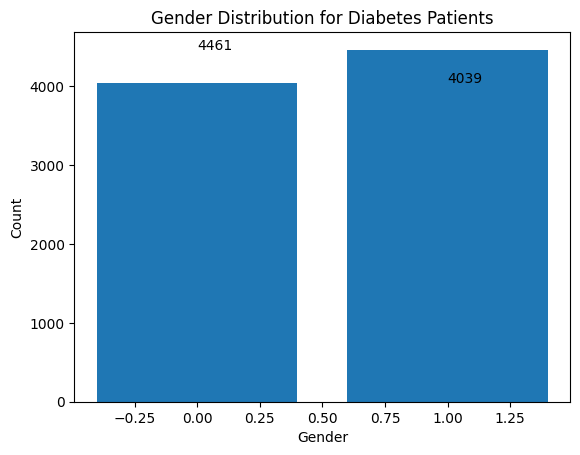

In [ ]:
# Convert menjadi pandas agar bisa membuat heatmap dan plotting
df_diabetes = diabetesDataset.toPandas()

# Memfilter data agar yang termasuk hanya pasien diabetes
diabetes_patient = df_diabetes[df_diabetes['diabetes'] == 1]

# Distribusi gender terhadap diabetes
gender_counts = diabetes_patient['gender'].value_counts()
plt.bar(gender_counts.index, gender_counts.values)
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Gender Distribution for Diabetes Patients')

def addLabels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i],y[i])

addLabels(gender_counts.index, gender_counts.values)

plt.show()

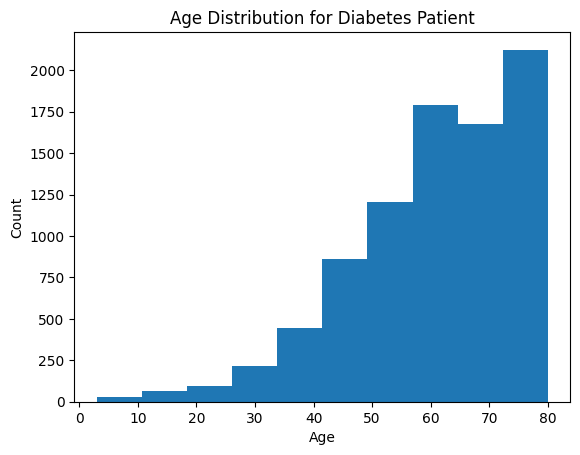

In [ ]:
# Distribusi usia terhadap diabetes
plt.hist(diabetes_patient['age'], bins=10)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Distribution for Diabetes Patient')
plt.show()

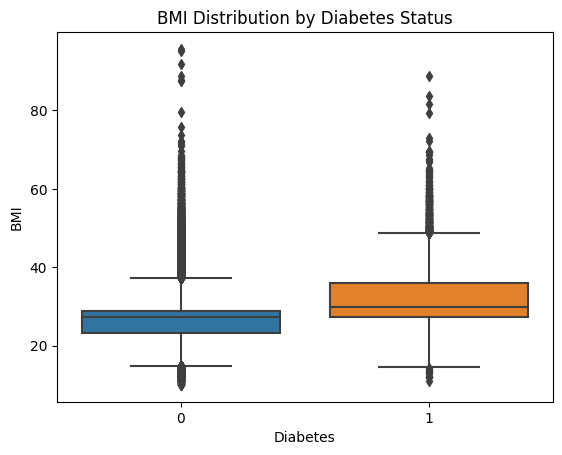

In [ ]:
# Distribusi BMI pada pasien diabetes dan non-diabetes
sns.boxplot(x=df_diabetes['diabetes'], y=df_diabetes['bmi'])
plt.xlabel('Diabetes')
plt.ylabel('BMI')
plt.title('BMI Distribution by Diabetes Status')
plt.show()

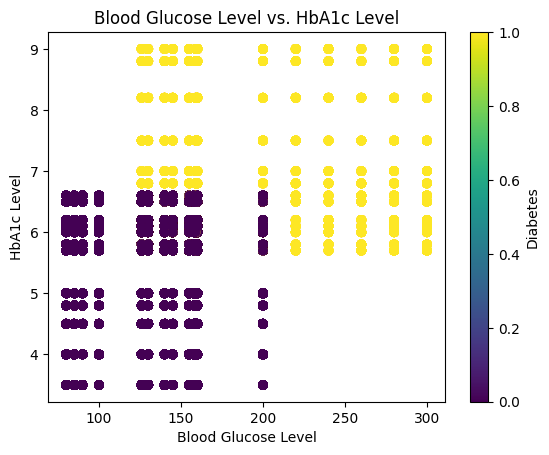

In [ ]:
# Relasi antara tigkat gula darah dan tingkat HbA1c
plt.scatter(df_diabetes['blood_glucose_level'], df_diabetes['HbA1c_level'], c=df_diabetes['diabetes'])
plt.xlabel('Blood Glucose Level')
plt.ylabel('HbA1c Level')
plt.title('Blood Glucose Level vs. HbA1c Level')
plt.colorbar(label='Diabetes')
plt.show()

<ipython-input-56-34402ef0a07a>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df_diabetes.corr()


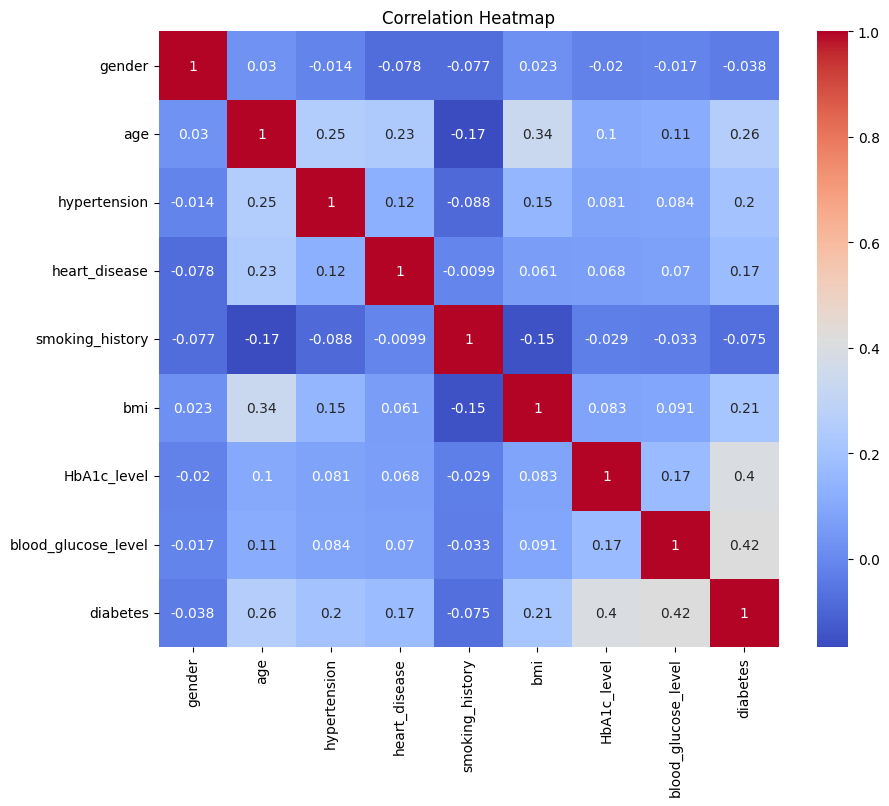

In [ ]:
# Heat map
# Correlation matrix adalah matrix yang menunjukan seberapa kuat hubungan antar fitur
correlation_matrix = df_diabetes.corr()

# Buat heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

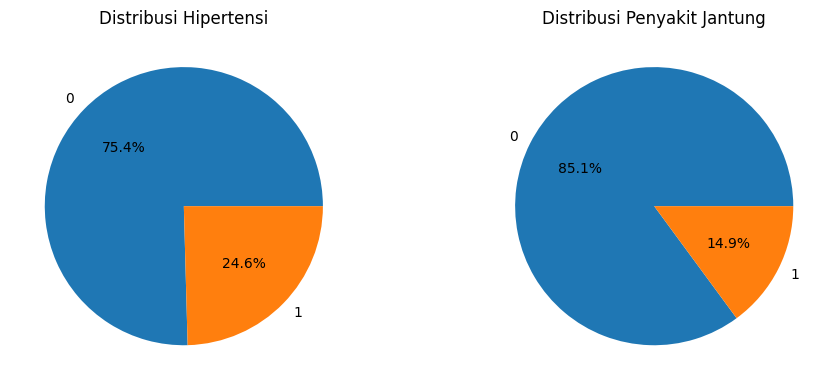

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Hypertension Distribution
hypertension_counts = diabetes_patient['hypertension'].value_counts()
axes[0].pie(hypertension_counts, labels=hypertension_counts.index, autopct='%1.1f%%')
axes[0].set_title('Distribusi Hipertensi')

# Distribusi
heart_disease_counts = diabetes_patient['heart_disease'].value_counts()
axes[1].pie(heart_disease_counts, labels=heart_disease_counts.index, autopct='%1.1f%%')
axes[1].set_title('Distribusi Penyakit Jantung')

plt.tight_layout()
plt.show()

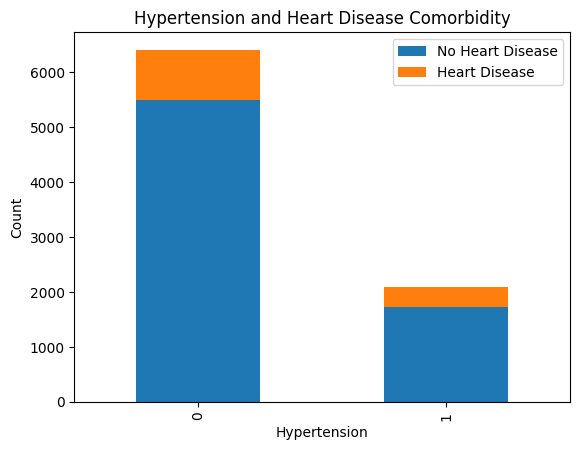

In [ ]:
# Jumlah pasien yang mengidap diabetes yang juga mengidap hipertensi dan penyakit jantung
comorbidity_counts = diabetes_patient.groupby(['hypertension', 'heart_disease']).size().unstack()
comorbidity_counts.plot(kind='bar', stacked=True)
plt.xlabel('Hypertension')
plt.ylabel('Count')
plt.title('Hypertension and Heart Disease Comorbidity')
plt.legend(['No Heart Disease', 'Heart Disease'])
plt.show()

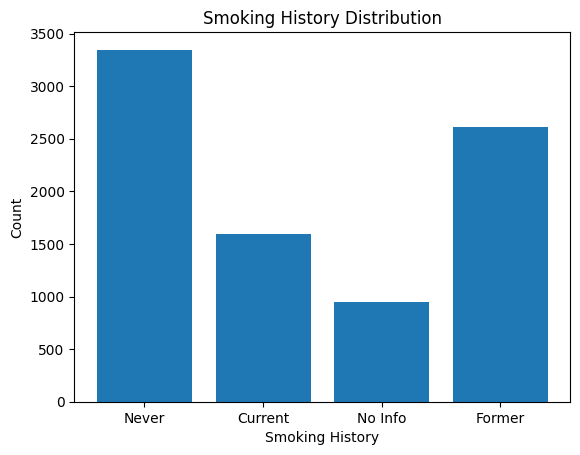

In [ ]:
labels = ['Never', 'Former', 'Current', 'No Info']
smoking_history_counts = diabetes_patient['smoking_history'].value_counts()
plt.bar(smoking_history_counts.index, smoking_history_counts.values)
plt.xlabel('Smoking History')
plt.ylabel('Count')
plt.title('Smoking History Distribution')
plt.xticks(smoking_history_counts.index, labels)
plt.show()

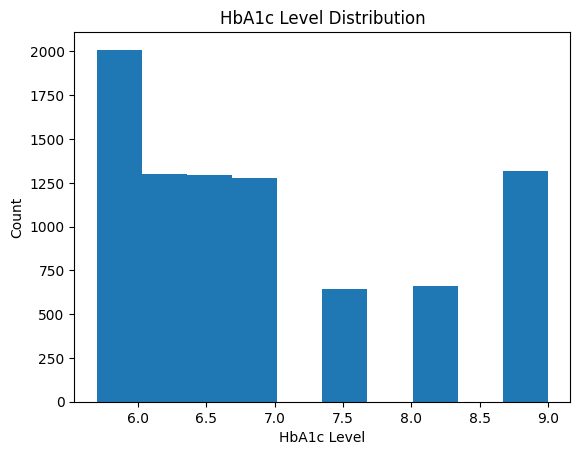

In [ ]:
plt.hist(diabetes_patient['HbA1c_level'], bins=10)
plt.xlabel('HbA1c Level')
plt.ylabel('Count')
plt.title('HbA1c Level Distribution')
plt.show()

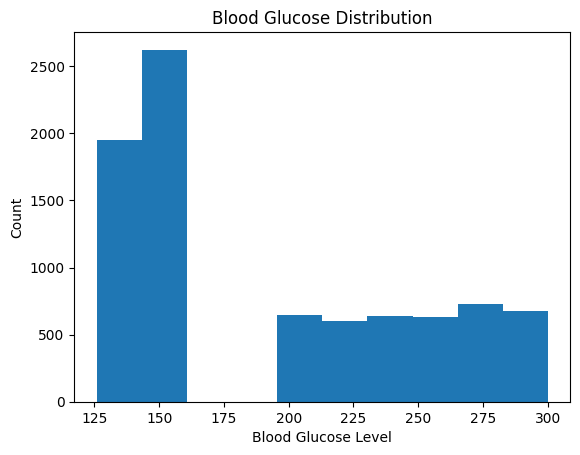

In [ ]:
plt.hist(diabetes_patient['blood_glucose_level'], bins=10)
plt.xlabel('Blood Glucose Level')
plt.ylabel('Count')
plt.title('Blood Glucose Distribution')
plt.show()

In [ ]:
# Tingkat kepentingan fitur
importances = model.featureImportances

feature_names = cols
feature_importance_dict = dict(zip(feature_names, importances))
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)


for feature, importance in sorted_feature_importance:
    print(f"{feature}: {importance*100}%")

HbA1c_level: 54.11260974305154%
blood_glucose_level: 40.03457069976843%
age: 3.118119611405159%
heart_disease: 1.0788258688959822%
bmi: 0.8138088253688089%
hypertension: 0.7319149182089176%
smoking_history: 0.10960060914142589%
gender: 0.0005497241597414248%
